In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

In [2]:
#A number of plots are displayed throughout the notebook, hide them
#by setting show_plots = False
show_plots = True

#Add noise to sensor readings?
add_noise = True

#Length of simulation [seconds]
#end_time = 500e-3
end_time = 5
#Sampling Frequency
fs = 16e3 # 16 kHz

#speed of sound in m/s
c = 343 

#Number of timesteps
#N = int(1e5)
N = int(end_time*fs)
print(N)

#Number of timesteps to generate the incoming sources
N_gen = int(1e6)

#True to use iterative method discussed in the paper (not implemented)
#False to use FASTICA (sklearn ICA implmentation)
iterative_method = False

80000


In [3]:
#initializing sources
s1 = np.zeros(N_gen)
s2 = np.zeros(N_gen)
s3 = np.zeros(N_gen)

dt = end_time/N_gen
t = np.linspace(0,end_time,N_gen)

#Source amplitudes and frequencies
source_freqs = np.array([2e3, 3e3, 5e3])
s1 = 10*np.sin(2*np.pi*source_freqs[0]*t)
s2 = 8*np.sin(2*np.pi*source_freqs[1]*t)
s3 = 12*np.sin(2*np.pi*source_freqs[2]*t)

sources = np.array([s1,s2,s3]).T
sources.shape

(1000000, 3)

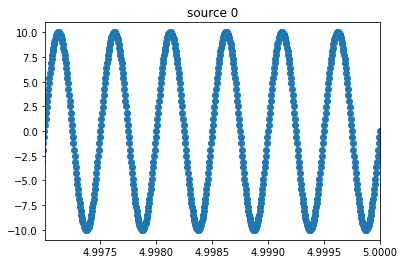

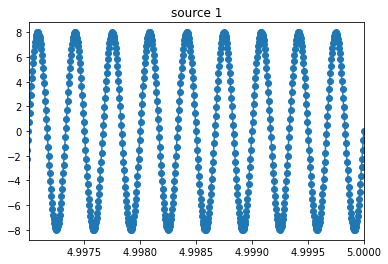

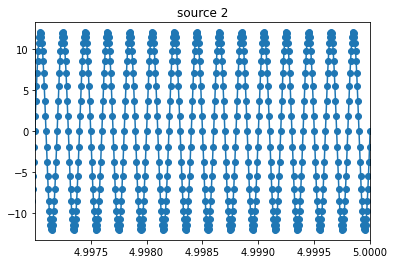

In [4]:
# Plotting the sources
# more useful when only simulating for a few periods

if show_plots:
    for i in range(3):
        plt.figure()
        plt.title('source ' + str(i))
        plt.scatter(t,sources[:,i])
        plt.plot(t,sources[:,i])
        plt.xlim(t[-(int(3e-3 / dt))], t[-1])
        
#The plots only show the last 3 ms of simulation

In [5]:
# Setting Source Locations 
# Units of [meters]

s1_loc = (8,8)
s2_loc = (3,-7)
s3_loc = (-5, 0)

source_locs = np.array([s1_loc,s2_loc,s3_loc]).T
source_locs.shape

(2, 3)

In [6]:
#Setting Microphone (Sensor) locations
# Units of [meters]

m1_loc = (-1e-2,0)
m2_loc = (1e-2,0)
m3_loc = (0,-1e-2)
m4_loc = (0,1e-2)

sensor_locs = np.array([m1_loc,m2_loc,m3_loc, m4_loc]).T
sensor_locs.shape

(2, 4)

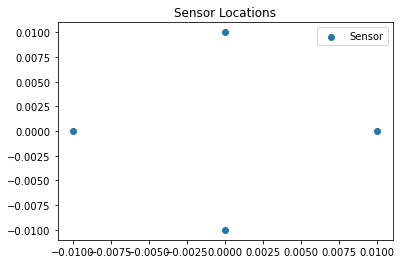

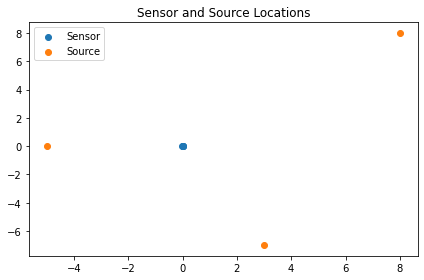

In [7]:
#Visualizing Placement

if show_plots:
    plt.figure()
    plt.scatter(sensor_locs[0,:], sensor_locs[1,:], label='Sensor')
    plt.title('Sensor Locations')
    plt.legend()
    plt.figure()
    plt.scatter(sensor_locs[0,:], sensor_locs[1,:], label='Sensor')
    plt.scatter(source_locs[0,:], source_locs[1,:], label='Source')
    plt.title('Sensor and Source Locations')
    plt.tight_layout()
    plt.legend()

In [8]:
# I think these are the correct r vectors, but not 100% 
# Vectors pointing along the horizontal and vertical sensor locations
# Hard coded, if sensor orientation is changed, this needs to be aswell

# r1 = [1,0]
# r2 = [0,1]
# R = np.array([r1,r2]).T
# R

In [9]:
# Function to get the delay between two positions 
# pos1 = (x,y)
# 2 tuples as input
def get_time_delay(pos1, pos2):
    dist = np.sqrt((pos2[1]-pos1[1])**2 + (pos2[0]-pos1[0])**2)
    return dist/c

In [10]:
# Calculating the delays using above function
# Dividing by dt to convert from seconds to timesteps 
# Each entry is the delay from source j to sensor i in number of timesteps
# delay_matrix[i][j]

delay_matrix = np.zeros((4,3))
print(delay_matrix.shape)
for i in range(0,4):
    for j in range(0,3):
        delay_matrix[i][j] = int(get_time_delay(sensor_locs[:,i], source_locs[:,j])/dt)

if show_plots:
    print('dt: ', dt)
    print('max: ', N_gen)
    print(delay_matrix)

# Below Comment was made when end_time = 2
# Its crazy this seems to work reasonable well even tho each source 
# only differs by a small index differenece (<10)
# Reducing end_time doesnt appear to improve accuracy much (about the same)

(4, 3)
dt:  5e-06
max:  1000000
[[6601. 4442. 2909.]
 [6592. 4438. 2921.]
 [6601. 4435. 2915.]
 [6592. 4446. 2915.]]


In [11]:
#Sensor Delays in time
if show_plots:
    print(delay_matrix*dt)

[[0.033005 0.02221  0.014545]
 [0.03296  0.02219  0.014605]
 [0.033005 0.022175 0.014575]
 [0.03296  0.02223  0.014575]]


In [12]:
#Computing sensor readings
sensor_readings = np.zeros((N_gen, 4))
for i,time in enumerate(t): #each timestep
    for j in range(4): #each microphone
        sensor_readings[i,j] = 0
        for c in range(3): #each source
            #If the current time index is greater than the delay 
            if i > delay_matrix[j,c] : 
                #include the source at this instance
                sensor_readings[i,j] += sources[int(i-delay_matrix[j,c]),c]

sensor_readings.shape

(1000000, 4)

In [13]:
#Sensor Readings (Input Microphones) 
#The plots only show the last 3 ms of simulation

#shown later with FFT (After adding noise)
# if show_plots:
#     for i in range(4):
#         plt.figure()
#         plt.plot(t, sensor_readings[:,i])
#         plt.xlim(t[-(int(3e-3 / dt))], t[-1])
#         plt.title('Sensor')

In [14]:
# #Adding Noise
if add_noise:
    sensor_readings[:,0] += np.random.normal(0, 1, N_gen)
    sensor_readings[:,1] += np.random.normal(0, 1.5, N_gen)
    sensor_readings[:,2] += np.random.normal(0, 2, N_gen)
    sensor_readings[:,3] += np.random.normal(0, 0.8, N_gen)

In [15]:
#SAMPLING
sensor_readings.shape
print(1/dt)
t_sample = np.linspace(0,end_time,N)
sensor_readings_sample = -1*np.ones((N, 4))
# Accurately generated the sensor readings assuming a very fast 
# sampling rate
# Now need to down sample to emulate the microphone sampling at 
# fs
j = 0
for i in range(N_gen):
    if t[i] >= t_sample[j]:
        sensor_readings_sample[j,:] = sensor_readings[i,:]
        j += 1
        

199999.99999999997


In [16]:
#Redefining for later use
dt = end_time/N
t = np.linspace(0,end_time,N)
sensor_readings = sensor_readings_sample

In [17]:
print(dt)

6.25e-05


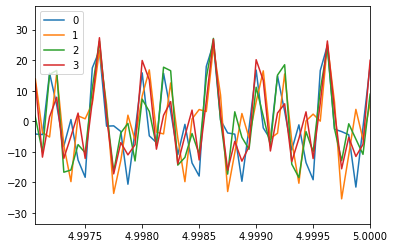

In [18]:
#Overlayed plots of sensor readings with added noise
# for the last 3 ms of simulation
if show_plots:
    for i in range(4):
        plt.plot(t,sensor_readings[:,i], label=str(i))
    plt.legend()
    plt.xlim(t[-(int(3e-3 / dt))], t[-1])

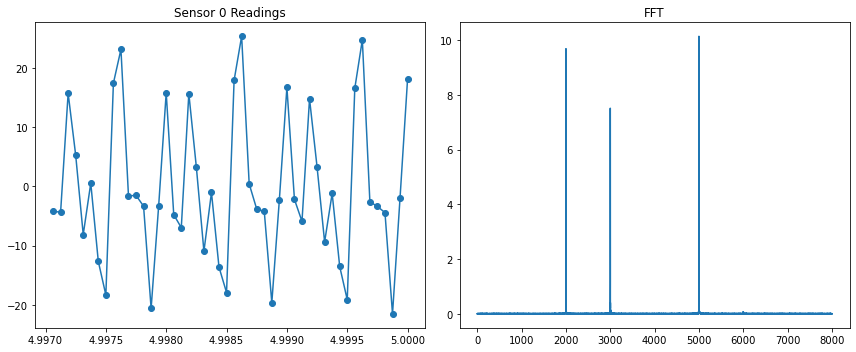

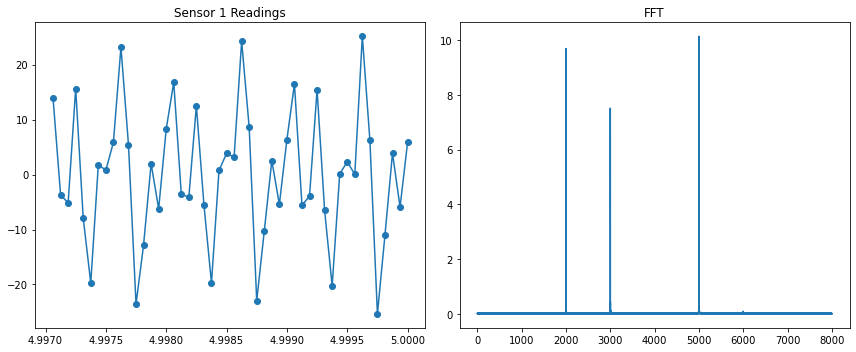

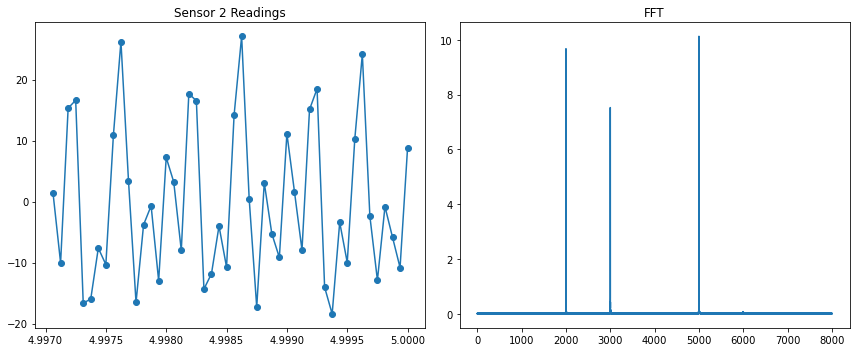

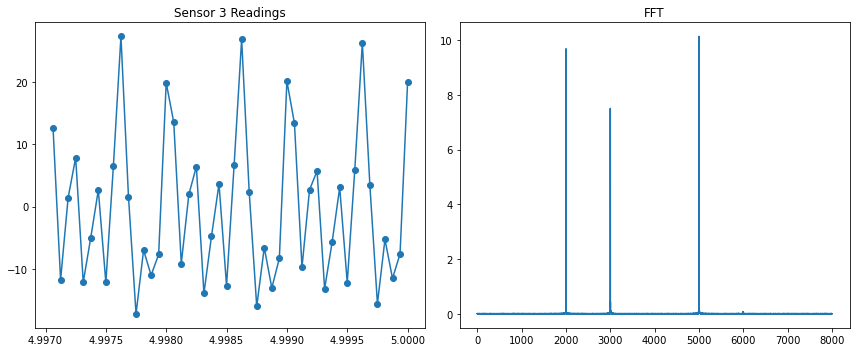

In [19]:
check_sensor_fft = True
if check_sensor_fft:
    for i in range(4):
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
        ax1.plot(t[-(int(3e-3 / dt)):], sensor_readings[-(int(3e-3 / dt)):, i])
        ax1.scatter(t[-(int(3e-3 / dt)):], sensor_readings[-(int(3e-3 / dt)):, i])
        ax1.set_title('Sensor ' +  str(i) + ' Readings')

        Y = fft(sensor_readings[:,i])
        L = len(sensor_readings[:,i])
        xf = fftfreq(L, dt)[:L//2]

        ax2.plot(xf, 2.0/L * np.abs(Y[0:L//2]))
        ax2.set_title('FFT')

        fig.tight_layout()

In [20]:
#Computing difference vector from the paper
e00 = (1/4) * np.sum(sensor_readings, axis=1)
e10 = (1/2) * (sensor_readings[:,1] - sensor_readings[:,0])
e01 = (1/2) * (sensor_readings[:,3] - sensor_readings[:,2])
print(e01.shape)
de00 = np.gradient(e00,t)

X = np.array([de00,e10, e01]).T

(80000,)


In [21]:
#Only considering the region where all 3 signals are present

# 1.1*max delay => start point is a bit after the last sensor is 
# detected
i1 = int(1.1*delay_matrix.max()*N/N_gen)
#Can cut off from the end as well if desired
i2 = int(N)
t1 = t[i1:i2]
X = X[i1:i2, :]
print(X.shape)



(79420, 3)


Saved Data


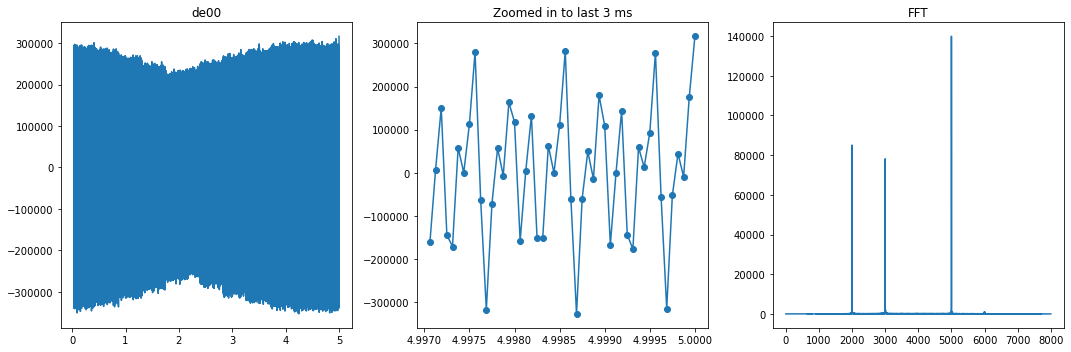

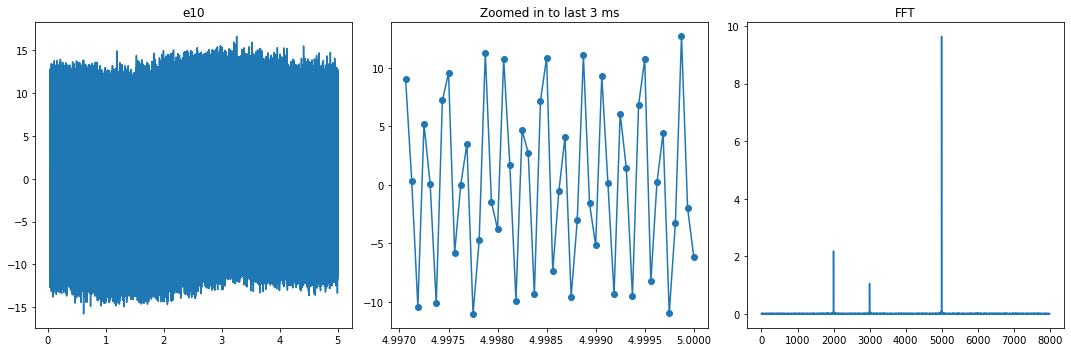

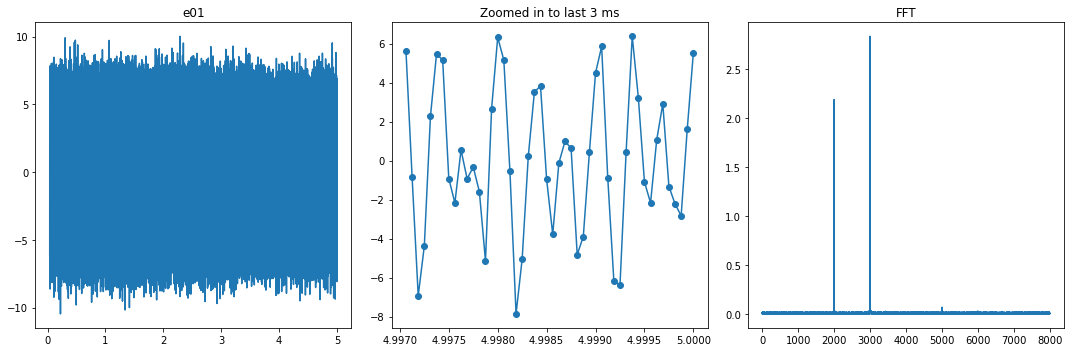

In [22]:
print('Saved Data')

for i in range(3):
    fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    ax1.plot(t1, X[:,i])
    if i == 0:
        ax1.set_title('de00')
    elif i == 1:
        ax1.set_title('e10')
    else:
        ax1.set_title('e01')
    
    ax2.plot(t1[-(int(3e-3 / dt)):], X[-(int(3e-3 / dt)):, i])
    ax2.scatter(t1[-(int(3e-3 / dt)):], X[-(int(3e-3 / dt)):, i])
    ax2.set_title('Zoomed in to last 3 ms')
    
    Y = fft(X[:,i])
    L = len(X[:,i])
    xf = fftfreq(L, dt)[:L//2]
    
    ax3.plot(xf, 2.0/L * np.abs(Y[0:L//2]))
    ax3.set_title('FFT')
    
    fig.tight_layout()
    
    

In [23]:
# Found some code online in matlab for online ICA, converted to other
# file formats to work with the computed sensor readings in other tools
np.savetxt('sensor_differences.txt', X)
np.savetxt('sensor_time.txt', t1)
# import scipy.io
# scipy.io.savemat('sensor_time.mat', dict(t=t1))
# scipy.io.savemat('sensor_differences.mat', dict(f1=X[:,0], f2=X[:,1],f3=X[:,2],))

In [24]:
#Sklearn ICA algorithm
if iterative_method == False:
    from sklearn.decomposition import FastICA
    transformer = FastICA(whiten=True)

    #X_transformed = Recovered Sources
    X_transformed = transformer.fit_transform(X)
    #params = transformer.get_params()
    print(X_transformed.shape)
    
    #Grabbing the mixing matrix
    # unmixer would be the inverse of the mixing matrix
    components = transformer.components_.copy()
    mixer = transformer.mixing_.copy()
    whiteM = transformer.whitening_.copy()
    print('Whitening Matrix:\n', whiteM)
    print('Unmixing Matrix:\n', components @ np.linalg.inv(whiteM))
    print('Mixing Matrix:\n', mixer)

else:
    print('Using Iterative Method')

(79420, 3)
Whitening Matrix:
 [[-2.39839326e-08  4.91157261e-13  7.14816122e-14]
 [-1.09602633e-08 -5.36182521e-04  6.71111298e-06]
 [ 3.22152301e-09  1.24577209e-05  9.95306185e-04]]
Unmixing Matrix:
 [[ 0.51936435  0.54147493 -0.66110936]
 [-0.67506426  0.73432362  0.07111307]
 [-0.52397416 -0.4093577  -0.74691188]]
Mixing Matrix:
 [[-2.16546784e+07  2.81465207e+07  2.18468826e+07]
 [-5.74567416e+02 -1.94483295e+03  3.06562695e+02]
 [-5.86945524e+02  4.68860299e+00 -8.24983503e+02]]


In [25]:
#Iterative Method
#Herault-Jutten Alogrithm 
if iterative_method == True:
    print()
    #Working Code should go here
    #Being developed in a seperate file
        
else:
    print('Using Sklearn Implementation')

Using Sklearn Implementation


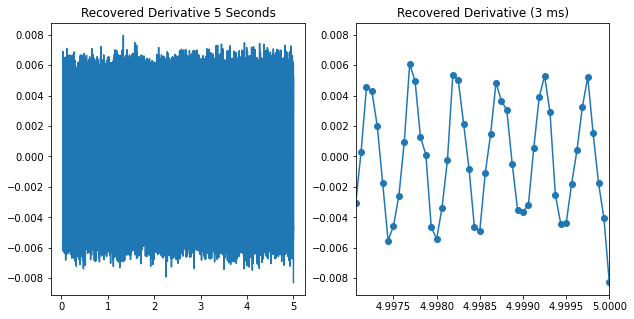

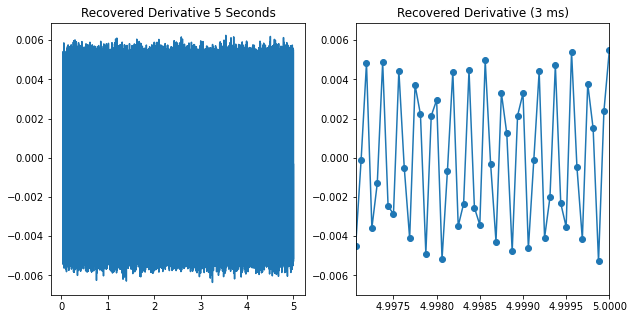

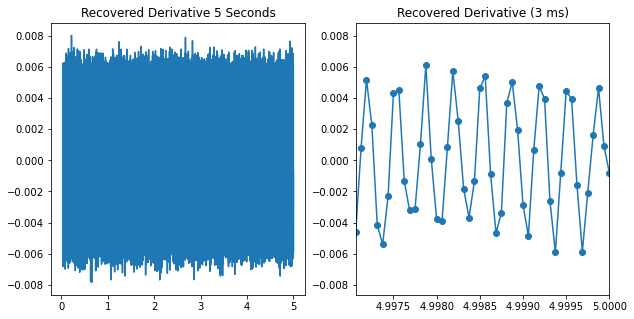

In [26]:
#Unscaled Recovered Values (source derivatives)

# These plots are always shown as they are useful in seeing if the
# source seperation worked as expected
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

    ax1.plot(t1, X_transformed[:,i])
    ax1.set_title('Recovered Derivative ' + str(end_time) + ' Seconds')

    ax2.plot(t1, X_transformed[:,i])
    ax2.scatter(t1, X_transformed[:,i])
    ax2.set_title('Recovered Derivative (3 ms)')
    ax2.set_xlim(t1[-(int(3e-3 / dt))], t1[-1])

In [27]:
# The recovered signal (below) appears to suffer from a low frequency 
# drift overtime (after numerical integration). Looking at the 
# derivative it seems to be well centered around 0 (especially if 
# you turn off the added noise), so this seems
# like a numerical error. After some googling it seems like this
# is somewhat of a common problem with numerical integration? 
#
# To get around this i just passed the data into a highpass filter 
# with a 50 Hz cutoff. Does this seem reasonable? Filtering the 
# integrated recovered signal has no effect on direction estimation

#Taking at the first signal above:
print('Integration over t: ', np.trapz(X_transformed[:,0],t1))
print('Mean: ', np.mean(X_transformed[:,0]))
print('Max: ', np.max(X_transformed[:,0]))
print('Min: ', np.min(X_transformed[:,0]))

# Looking at these values and plots I would expect the 
# recovered signal to be a sinusoid centered at 0 but 
# the center of the resulting sinusoid changes over time
# shown below

Integration over t:  9.938789974477245e-08
Mean:  1.0615406815974921e-19
Max:  0.007968599976208548
Min:  -0.008284844245463312


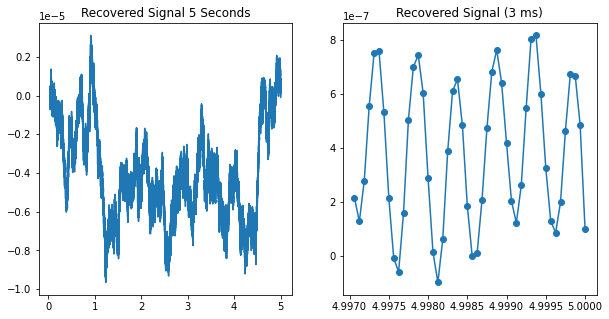

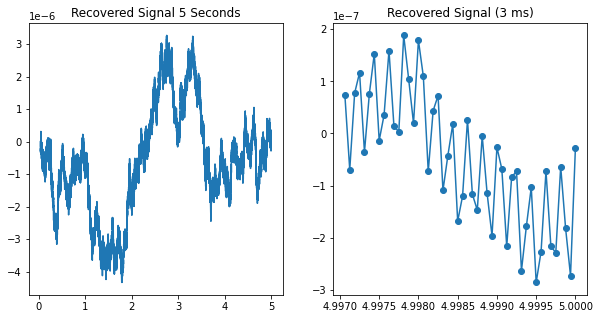

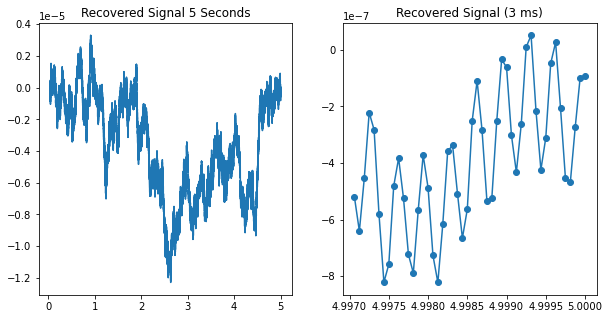

In [28]:
from scipy import integrate
if show_plots:
    for i in range(3):
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
        recovered_source = integrate.cumtrapz(X_transformed[:,i], t1, initial=0)
        
        ax1.plot(t1, recovered_source)
        ax1.set_title('Recovered Signal ' + str(end_time) + ' Seconds')
        
        ax2.plot(t1[-(int(3e-3 / dt)):], recovered_source[-(int(3e-3 / dt)):])
        ax2.scatter(t1[-(int(3e-3 / dt)):], recovered_source[-(int(3e-3 / dt)):])
        ax2.set_title('Recovered Signal (3 ms)')
        #ax2.set_xlim(t1[-(int(3e-3 / dt))], t1[-1])

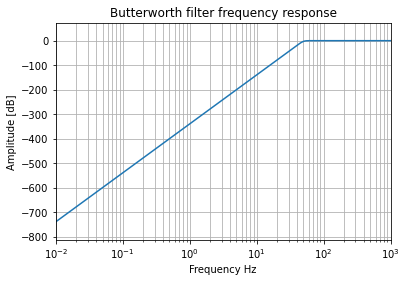

In [29]:
#getting the coeffs for a filter
from scipy import signal

b, a = signal.butter(10, 50, 'highpass', analog=True)
sos = signal.butter(10, 50, 'highpass', fs=(1/dt), output='sos')
w, h = signal.freqs(b, a)
if show_plots:
    plt.semilogx(w, 20 * np.log10(abs(h)))
    plt.title('Butterworth filter frequency response')
    #Could be rad/s but it should match the units of fs
    plt.xlabel('Frequency Hz')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.show()

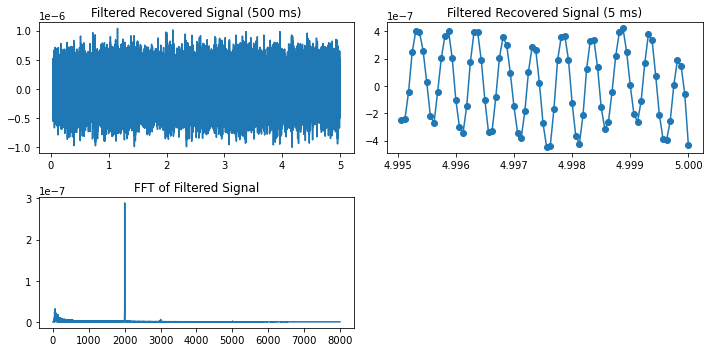

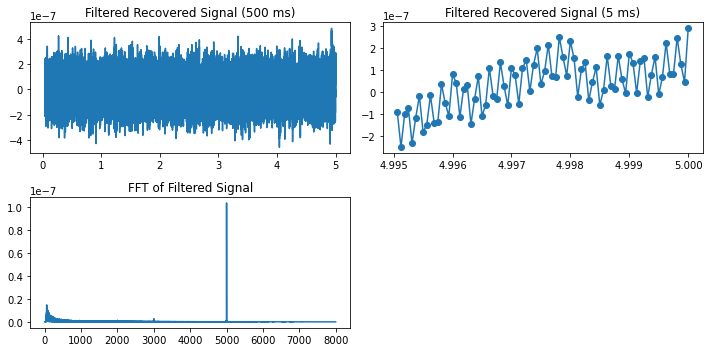

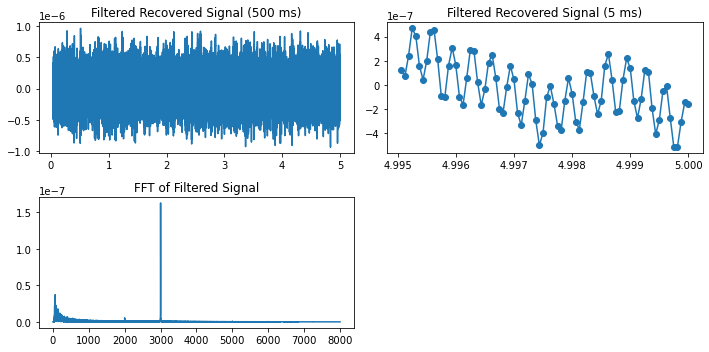

In [35]:
#Recovered Sources
from scipy.fft import fft, fftfreq
center_freqs = np.zeros(3)

for i in range(3):
    recovered_source = integrate.cumtrapz(X_transformed[:,i], t1, initial=0)
    filtered = signal.sosfilt(sos, recovered_source)

    Y = fft(filtered)
    L = len(filtered)
    xf = fftfreq(L, dt)[:L//2]

    center_freqs[i] = xf[np.abs(Y[0:L//2]).argmax()]

    if show_plots:
        fig, axs = plt.subplots(2,2,figsize=(10,5))
        axs[0,0].plot(t1, filtered)
        axs[0,0].set_title('Filtered Recovered Signal (500 ms)')

        axs[1,0].plot(xf, 2.0/L * np.abs(Y[0:L//2]))
        axs[1,0].set_title('FFT of Filtered Signal')

        axs[0,1].plot(t1[-(int(5e-3 / dt)):], filtered[-(int(5e-3 / dt)):])
        axs[0,1].scatter(t1[-(int(5e-3 / dt)):], filtered[-(int(5e-3 / dt)):])
        axs[0,1].set_title('Filtered Recovered Signal (5 ms)')
        #axs[0,1].set_xlim(t1[-(int(5e-3 / dt))], t1[-1])
        axs[-1, -1].axis('off')
        fig.tight_layout()

#I dont think ICA can recover signal ampltiudes, so the derivatives 
#computed earlier (X_tranformed) are likely not the exact source 
#derivatives
# => Recovered signals are not scaled to match the original sources
# but frequency information is retained
#Source: https://sccn.ucsd.edu/pipermail/eeglablist/2014/007575.html

In [31]:
#Normalizing the columns of the mixing matrix to obtain tau
# per the papers
top_val = np.ones(3)
for i in range(0,3):
    top_val[i] = mixer[0,i]
    mixer[:,i] = mixer[:,i]/top_val[i]
mixer

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 2.65331771e-05, -6.90967442e-05,  1.40323313e-05],
       [ 2.71047907e-05,  1.66578421e-07, -3.77620697e-05]])

In [32]:
# In order to calculate the directions 
# Multiplying the tau values by c (speed of sound)
# and normalzing to length 1 
# I didnt actually programmatically use the r vectors defined earlier
# This math assumes r1 = [1,0] and r2 = [0,1], turns the dot products
# into scalar products and makes solving much easier

dirs = c * mixer[1:,:]
for i in range(0,3):
    dirs[:,i] = dirs[:,i]/(np.linalg.norm(dirs[:,i]))
np.round(dirs,3)

array([[ 0.7  , -1.   ,  0.348],
       [ 0.715,  0.002, -0.937]])

In [33]:
#Printing Results
#Dir = directly calculated from entered values (ground truth)
#Measured = calculaed with ICA method
#NOTE: as far as i know theres no reason to expect the direction 
#vectors to be in the same order

#Calculating angle as the dot product with [1,0]
#Angle reported in degrees
for i in range(3):
    dir_vector = source_locs[:,i]/np.linalg.norm(source_locs[:,i])
    print('Source', i, 'Loc:', source_locs[:,i], 
          '\tDir:', dir_vector, 
          '\n\t\t\tAngle: ', np.arccos(dir_vector @ [1,0]) * (180/np.pi),
          '\n\t\t\tFrequency: ', source_freqs[i])
print()
for i in range(3):
    print('Measured Dir :\t', np.round(dirs[:,i],4),
         '\n\tAngle:\t', np.arccos(dirs[:,i] @ [1,0]) * (180/np.pi),
         '\n\tFreq:\t', center_freqs[i])

Source 0 Loc: [8 8] 	Dir: [0.70710678 0.70710678] 
			Angle:  45.00000000000001 
			Frequency:  2000.0
Source 1 Loc: [ 3 -7] 	Dir: [ 0.3939193  -0.91914503] 
			Angle:  66.80140948635182 
			Frequency:  3000.0
Source 2 Loc: [-5  0] 	Dir: [-1.  0.] 
			Angle:  180.0 
			Frequency:  5000.0

Measured Dir :	 [0.6995 0.7146] 
	Angle:	 45.61057134138076 
	Freq:	 2000.1007302946362
Measured Dir :	 [-1.      0.0024] 
	Angle:	 179.8618716104328 
	Freq:	 5000.050365147318
Measured Dir :	 [ 0.3483 -0.9374] 
	Angle:	 69.61500559873255 
	Freq:	 2999.9496348526823
